In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns


Data structure obtained after combining input files in previous step:
- id
- title - scientific work title
- year - publication year
- reference
- authors
- n_citation
- venue - conference or journal where the scientific work was published
- gov_score


In [62]:
df = pd.read_csv("../data/interim//articles_with_score_df.csv",
    usecols=[
        'gov_score', 
        'n_citation', 
        'year', 
        'title'
    ]
)

In [63]:
display(df)

,title,year,n_citation,gov_score
0,Software Evolution through Transformations.,2003,50,40
1,Context Dependent Automatic Textile Image Anno...,2007,50,20
2,On the signed total chromatic number of a graph.,2006,7,40
3,Traveling wave solutions of the n-dimensional ...,2012,6,100
4,Special issue on causal modeling: Preface.,1989,0,40
...,...,...,...,...
850401,Condorcet Consistent Bundling with Social Choice.,2017,0,70
850402,Cloudy with a Chance of Poaching: Adversary Be...,2017,0,70
850403,A Deterministic Distributed Algorithm for Reas...,2017,50,70
850404,Mobile Platforms and Multi-Mobile Platform Dev...,2014,50,20


In [64]:
df_sample = df.sample(n=1000, random_state=1)

## a) Analysis of Gov Score in Relation to Citation Count and Publication Year

In [65]:
dimensions_sample_df = df_sample[['gov_score', 'n_citation', 'year']]

This code visualizes the relationship between the governance score (`gov_score`), number of citations (`n_citation`), and publication year (`year`) for a sample of scientific articles.
The scatter plot uses a logarithmic scale for the citation count (x-axis)

Key insights from the visualization:

- Articles with high governance scores tend to be those that have many citations and are relatively recent.

- Publications with low citation counts generally have low governance scores, and vice versa.

This suggests that both the impact (citations) and the recency of an article correlate positively with its governance score, providing evidence that newer and highly cited works are valued more in this scoring system.

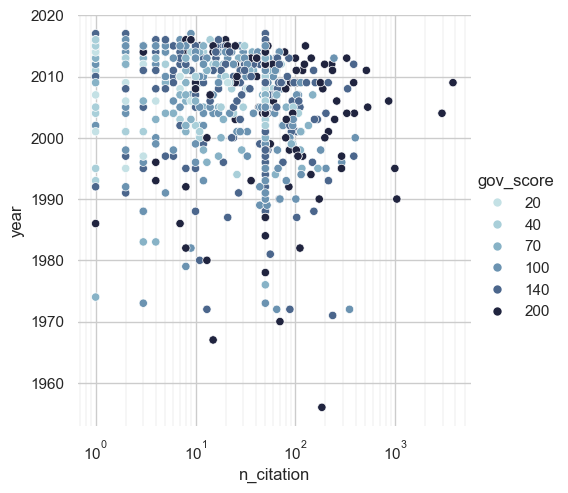

In [ ]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=dimensions_sample_df,
    x="n_citation", y="year",
    hue="gov_score",
    palette=cmap
)
g.set(xscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

This plot presents a rotated view of the previous analysis, displaying publication year on the x-axis and number of citations on the y-axis (on a logarithmic scale). The points are colored by governance score (`gov_score`).
The logarithmic scale on the y-axis highlights the wide range of citation counts.


Key observations:

- Articles with high governance scores are generally those with many citations and recent publication years.

- Items with few citations tend to have low governance scores, confirming the positive correlation.

- The visualization also shows that as both the publication year and citation counts increase, the variability in governance scores decreases, indicating more consistent scoring among newer, well-cited articles.

This supports the conclusion that favoring younger publications in scoring is justified, since newer articles tend to be rated higher, possibly reflecting better quality or relevance.

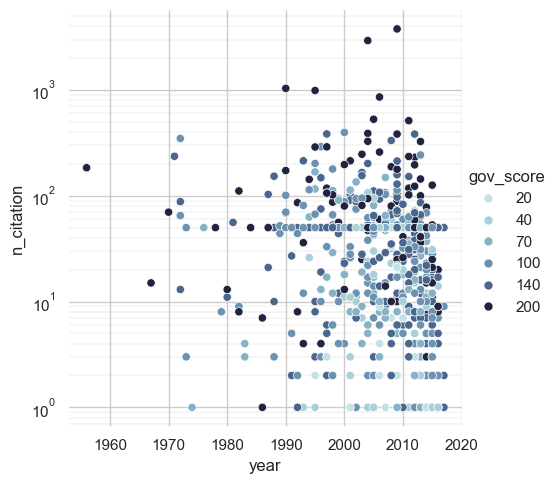

In [ ]:
sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=dimensions_sample_df,
    x="year", y="n_citation",
    hue="gov_score",
    palette=cmap
)
g.set(yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

## b) Analysis of title embedding

In [76]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [77]:
if torch.cuda.is_available():
    print("CUDA is available: ", torch.cuda.is_available())   
    print("Number of CUDA devices: ", torch.cuda.device_count())
    print("CUDA current device: ", torch.cuda.current_device())
    print("CUDA device name: ", torch.cuda.get_device_name(0))

    model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')
else:
    model = SentenceTransformer("all-MiniLM-L6-v2", device='cpu')

CUDA is available:  True
Number of CUDA devices:  1
CUDA current device:  0
CUDA device name:  NVIDIA GeForce RTX 3060 Laptop GPU


Prepare title embedding

In [ ]:
titles = df_sample['title'].tolist()

titles_embeddings = model.encode(titles, show_progress_bar=True)
df_sample['embedding'] = list(titles_embeddings)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [71]:
display(titles_embeddings)


array([[-0.01760289, -0.01681715, -0.01091906, ...,  0.06338207,
         0.00933767, -0.04340767],
       [ 0.00597781, -0.03034817, -0.02649775, ..., -0.03049326,
        -0.07791914, -0.06127868],
       [ 0.02993399,  0.03473874,  0.03331954, ..., -0.01712735,
         0.0653508 ,  0.05716813],
       ...,
       [-0.05895468, -0.07544591,  0.11254185, ...,  0.03826065,
         0.01398549,  0.03553828],
       [-0.03705016, -0.03917208,  0.0298158 , ..., -0.03502068,
         0.02816515,  0.01686673],
       [ 0.01751595, -0.0365766 , -0.00083154, ..., -0.03538078,
         0.05929954, -0.01357308]], dtype=float32)

📉 Dimensionality Reduction with PCA

The code below performs Principal Component Analysis (PCA) to reduce the high-dimensional title embeddings (e.g., 384-dimensional vectors) to just 2 dimensions.

The `explained_variance_ratio_` shows how much of the original data's variance is captured by each principal component.

The `singular_values_` indicate the strength (spread) of each dimension in the reduced space.


The PCA output reveals that each of the two components captures only a small fraction of the total variance — for example, around 3% per component. This means:

- The embeddings are highly dispersed in the original space.

- Their meaningful structure is spread across many dimensions, making them difficult to project meaningfully into 2D.

In [78]:
X = np.stack(df_sample['embedding'].values)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Wyświetlenie, ile wariancji tłumaczy każdy składnik PCA
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Singular values:", pca.singular_values_)

Explained variance ratio: [0.03839095 0.03558622]
Singular values: [6.00796  5.784336]


In [80]:
df_x = pd.DataFrame(X_reduced, columns=['x', 'y'])
display(df_x.head())

,x,y
0,-0.303985,0.292801
1,0.184616,-0.292328
2,-0.145587,-0.037114
3,0.000544,0.150591
4,0.108199,0.155700


🧠 Interpretation

This plot visualizes the 2D projection of title embeddings, providing insight into their spatial distribution. Articles clustered near coordinates like (-2, -2) likely share similar titles and semantic content. The closer the titles appear in the embedding space, the more semantically similar they are; distant points indicate greater textual dissimilarity.

<Axes: xlabel='x', ylabel='y'>

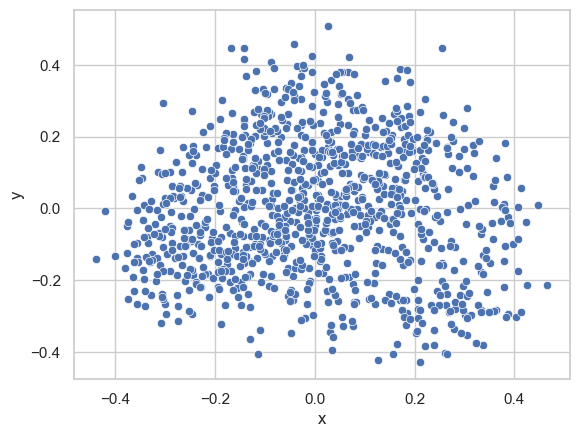

In [ ]:

sns.set_theme(style="whitegrid")
sns.scatterplot(x='x', y="y",
                data=df_x)

###  PCA on Combined Embeddings and Numerical Features

In this step, `title embeddings` with additional numerical features (`gov_score`, `n_citation`, `year`) were combined into a single feature matrix and applied **PCA for 2D dimensionality reduction**. However, the explained variance of the first two components remains very low (around 3% each), indicating that the transformation still fails to capture meaningful structure in 2D space.

The resulting scatter plot shows no clear patterns or clusters — suggesting that the added features do not significantly improve the separability or interpretability of the embedding space in 2D. 

[0.91396691 0.08361631]
[5297.39120069 1602.2944053 ]


,x,y
0,0.624197,9.777781
1,7.072765,-89.933860
2,0.701987,9.517485
3,298.166816,28.504202
4,-1.340538,39.792220


<Axes: xlabel='x', ylabel='y'>

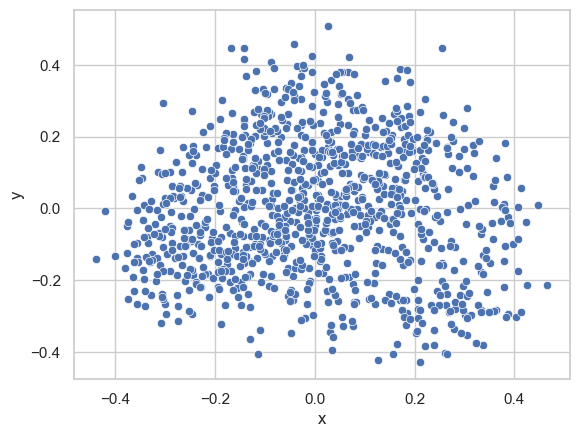

In [83]:
empedings = np.stack(df_sample['embedding'].values) # shape (1000, 384)
dimensions = df_sample[['gov_score', 'n_citation', 'year']].to_numpy() # shape (1000, 3)
X = np.hstack((empedings, dimensions)) # shape (1000, 387) 


X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

df = pd.DataFrame(X_pca, columns=['x', 'y'])
display(df.head())

sns.set_theme(style="whitegrid")
sns.scatterplot(x='x', y="y",
                data=df_x)
